img ratio 0.17108251324753973
{0: {'median': 0.002300139982253312, 'p90': 0.012180007062852799, 'frac': {0.02: 0.9407894736842107, 0.05: 0.9868421052631581, 0.1: 0.9978070175438598}}, 1: {'median': 0.0040605751353062014, 'p90': 0.022331120971251384, 'frac': {0.02: 0.8737240829346091, 0.05: 0.9807017543859647, 0.1: 0.994736842105263}}, 2: {'median': 0.010226126760244364, 'p90': 0.04467047527432452, 'frac': {0.02: 0.7342342342342342, 0.05: 0.9234234234234233, 0.1: 0.9797297297297297}}}
[cone] geom-fair median=0.002, p90=0.012)
[cuboid] geom-fair median=0.004, p90=0.022)
[cylinder] geom-fair median=0.010, p90=0.045)
cone N_samples 456 N_geoms 38 min/med/max 0.0002235856227343902 0.0023162632714957 0.11107043921947479
cuboid N_samples 300 N_geoms 38 min/med/max 0.00017524238501209766 0.0032837123144418 0.12765711545944214
cylinder N_samples 444 N_geoms 37 min/med/max 4.051961877848953e-05 0.010285891592502594 0.2724027633666992
savepath figs/figure_4.png


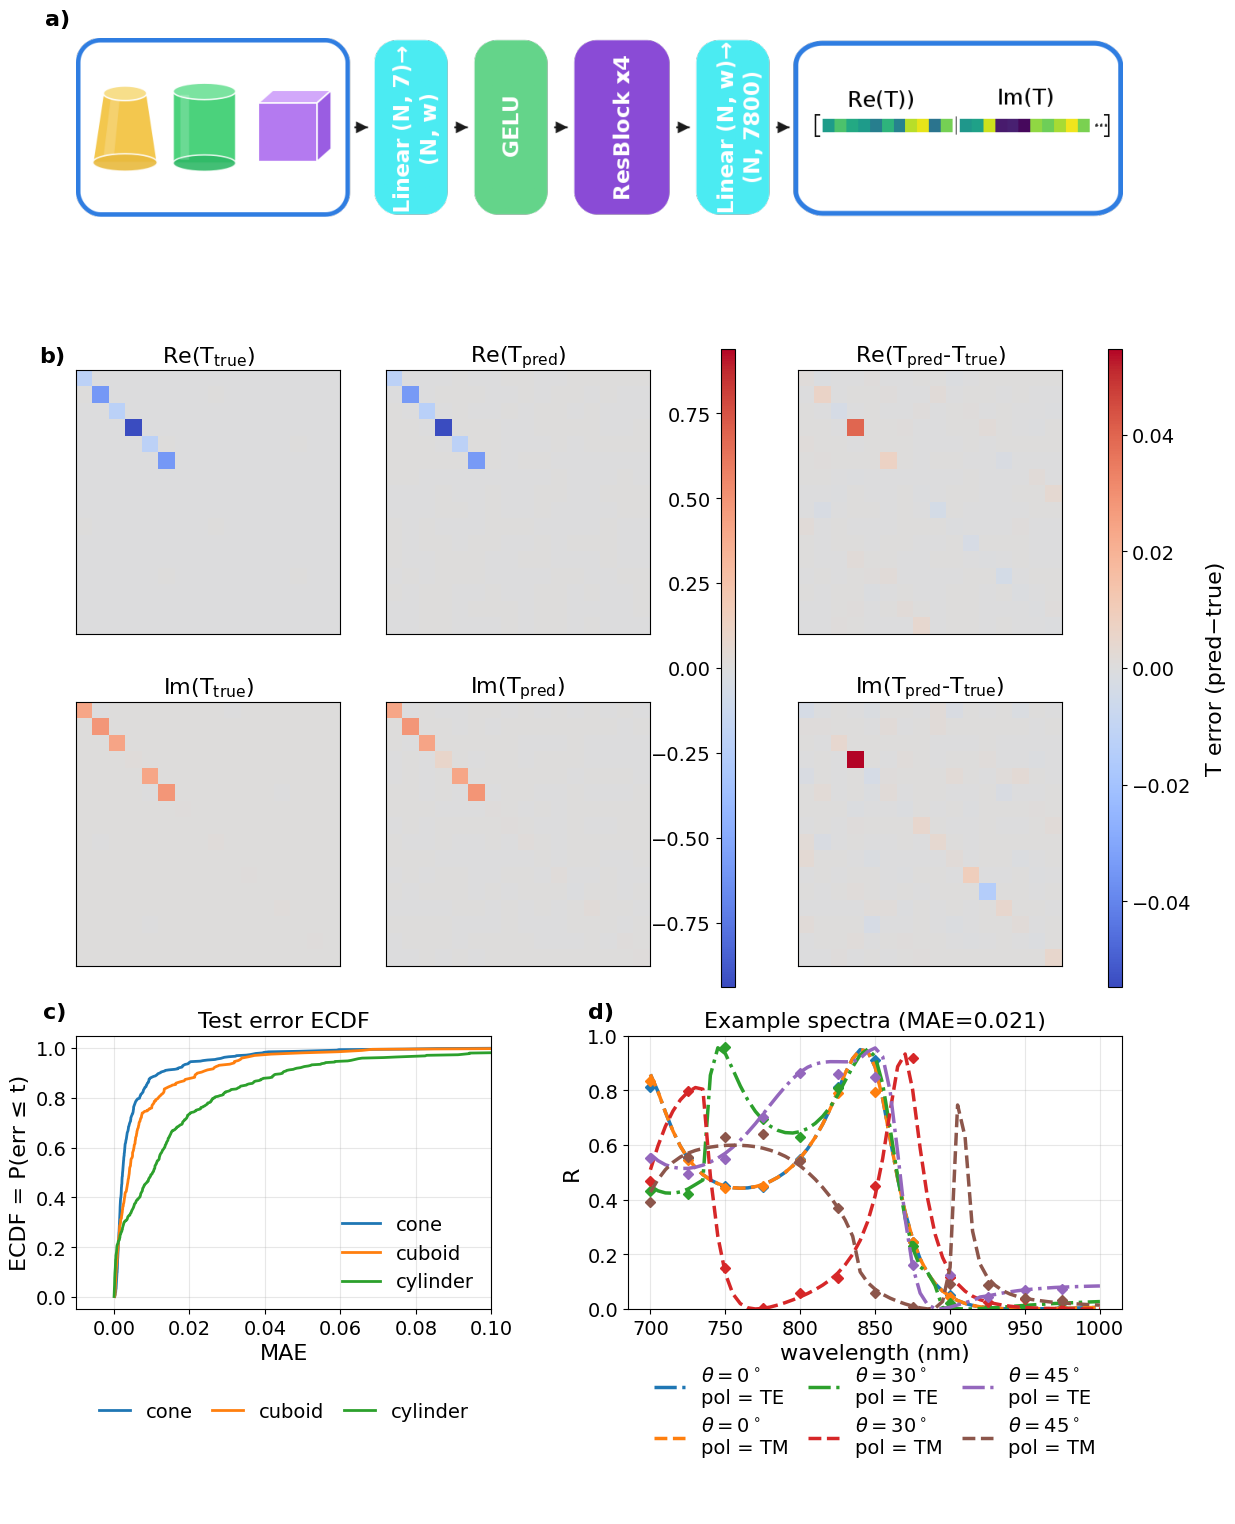

In [1]:
#!/usr/bin/env python3
"""
Plot from saved HDF5 results.
"""

from pathlib import Path

import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# -----------------------
# User config
# -----------------------
H5_PATH = Path(
    "results/paramtot_results.h5"
)
TOP_PNG_PATH = Path("figs/tot.png")
OUT_FIG_PATH = Path("figs/figure_4.png")


def set_mpl_style(font_size=16):
    mpl.rcParams.update(
        {
            "font.size": font_size,
            "axes.titlesize": font_size,
            "axes.labelsize": font_size,
            "xtick.labelsize": font_size - 2,
            "ytick.labelsize": font_size - 2,
            "legend.fontsize": font_size - 2,
            "figure.titlesize": font_size,
        }
    )


def decode_h5_strings(x):
    """Decode bytes returned by h5py into python strings."""
    if isinstance(x, (bytes, np.bytes_)):
        return x.decode("utf-8")
    if isinstance(x, np.ndarray) and x.dtype.kind in ("S", "O"):
        out = []
        for v in x:
            out.append(decode_h5_strings(v))
        return np.array(out, dtype=object)
    return x


def weighted_quantile(x, w, qs):
    x = np.asarray(x).ravel()
    w = np.asarray(w).ravel()
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    order = np.argsort(x)
    x, w = x[order], w[order]
    cw = np.cumsum(w) / np.sum(w)
    return np.interp(qs, cw, x)


def geom_fair_weights(gid):
    """Weights so each geometry contributes total weight 1."""
    gid = np.asarray(gid).ravel()
    uniq, counts = np.unique(gid, return_counts=True)
    cdict = dict(zip(uniq, counts))
    return np.array([1.0 / cdict[g] for g in gid], dtype=float)


def weighted_ecdf(x, w):
    """Return sorted x and weighted empirical CDF."""
    x = np.asarray(x).ravel()
    w = np.asarray(w).ravel()
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    order = np.argsort(x)
    xs = x[order]
    ws = w[order]
    cdf = np.cumsum(ws) / np.sum(ws)
    return xs, cdf


def summarize_by_class(err, y, gid, thresholds=(0.02, 0.05, 0.10)):
    err = np.asarray(err).ravel()
    y = np.asarray(y).ravel().astype(int)
    gid = np.asarray(gid).ravel()
    w_all = geom_fair_weights(gid)

    out = {}
    for c in np.unique(y):
        m = y == c
        q50, q90 = weighted_quantile(err[m], w_all[m], [0.5, 0.9])
        fracs = {t: float(np.sum(w_all[m][err[m] <= t]) / np.sum(w_all[m])) for t in thresholds}
        out[int(c)] = dict(median=float(q50), p90=float(q90), frac=fracs)
    return out


def plot_weighted_cdf_by_class(
    err,
    labels,
    gids,
    class_ids=None,
    class_names=None,
    ax=None,
    title="ECDF (test set)",
    xlabel="error",
    logx=False,
):
    err = np.asarray(err).ravel()
    labels = np.asarray(labels).ravel().astype(int)
    gids = np.asarray(gids).ravel()
    w_all = geom_fair_weights(gids)

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    if class_ids is None:
        class_ids = np.unique(labels)

    for cid in class_ids:
        m = labels == cid
        if m.sum() == 0:
            continue

        xs, cdf = weighted_ecdf(err[m], w_all[m])
        q50, q90 = np.interp([0.5, 0.9], cdf, xs)

        if class_names is None:
            name = str(int(cid))
        else:
            name = str(class_names[int(cid)])

        print(f"[{name}] geom-fair median={q50:.3f}, p90={q90:.3f})")
        ax.plot(xs, cdf, lw=2, label=name)

    ax.set_xlim(-0.01, 0.1)
    if logx:
        ax.set_xscale("log")

    ax.set_xlabel(xlabel)
    ax.set_ylabel("ECDF = P(err ≤ t)")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    ax.legend(frameon=False)
    return ax


def plot_T_matrices_axes(axes, T_true, T_pred, cmap="coolwarm", q=99.9):
    lnth = 16
    T_pred = T_pred[:lnth, :lnth]
    T_true = T_true[:lnth, :lnth]
    diff = T_pred - T_true

    tp_vals = np.abs(
        np.r_[
            T_true.real.ravel(),
            T_true.imag.ravel(),
            T_pred.real.ravel(),
            T_pred.imag.ravel(),
        ]
    )
    err_vals = np.abs(np.r_[diff.real.ravel(), diff.imag.ravel()])
    vmax_tp = np.percentile(tp_vals, q)
    vmax_e = np.percentile(err_vals, q)

    im_tp = axes[0, 0].imshow(
        T_true.real, vmin=-vmax_tp, vmax=vmax_tp, aspect="equal", cmap=cmap, interpolation="nearest"
    )
    axes[0, 0].set_title(r"Re(T$_\mathrm{true}$)")
    axes[0, 1].imshow(
        T_pred.real, vmin=-vmax_tp, vmax=vmax_tp, aspect="equal", cmap=cmap, interpolation="nearest"
    )
    axes[0, 1].set_title(r"Re(T$_\mathrm{pred}$)")
    im_err = axes[0, 2].imshow(
        diff.real, vmin=-vmax_e, vmax=vmax_e, aspect="equal", cmap=cmap, interpolation="nearest"
    )
    axes[0, 2].set_title(r"Re(T$_\mathrm{pred}$-T$_\mathrm{true}$)")

    axes[1, 0].imshow(
        T_true.imag, vmin=-vmax_tp, vmax=vmax_tp, aspect="equal", cmap=cmap, interpolation="nearest"
    )
    axes[1, 0].set_title(r"Im(T$_\mathrm{true}$)")
    axes[1, 1].imshow(
        T_pred.imag, vmin=-vmax_tp, vmax=vmax_tp, aspect="equal", cmap=cmap, interpolation="nearest"
    )
    axes[1, 1].set_title(r"Im(T$_\mathrm{pred}$)")
    axes[1, 2].imshow(
        diff.imag, vmin=-vmax_e, vmax=vmax_e, aspect="equal", cmap=cmap, interpolation="nearest"
    )
    axes[1, 2].set_title(r"Im(T$_\mathrm{pred}$-T$_\mathrm{true}$)")

    for ax in axes.ravel():
        ax.set_xticks([])
        ax.set_yticks([])

    return im_tp, im_err, diff


def plot_spectra_for_gid(
    ax,
    gid,
    te_gid,
    wl_te,
    R_true_te,
    R_pred_te,
    *,
    R_ref,
    wl_ref,
    angles=None,
    ang_ids=(0, 1, 2),
    n_angles=3,
    n_pols=2,
    pol_ids=(0,),
    title="",
    ylim=(0, 1.05),
):
    if angles is None:
        raise ValueError("angles must be provided.")

    m = te_gid == gid

    w = np.asarray(wl_te[m])
    Rt = np.asarray(R_true_te[m])
    Rp = np.asarray(R_pred_te[m])

    order = np.argsort(w)
    w, Rt, Rp = w[order], Rt[order], Rp[order]

    if Rt.ndim == 2 and Rt.shape[1] == n_angles * n_pols:
        Rt = Rt.reshape(Rt.shape[0], n_angles, n_pols)
        Rp = Rp.reshape(Rp.shape[0], n_angles, n_pols)
    elif Rt.ndim == 2 and Rt.shape[1] == n_angles and n_pols == 1:
        Rt = Rt[:, :, None]
        Rp = Rp[:, :, None]
    else:
        raise ValueError(f"Unexpected Rt shape {Rt.shape}; expected [npts,{n_angles*n_pols}]")

    if R_ref.ndim == 2 and R_ref.shape[1] == n_angles * n_pols:
        R_ref = R_ref.reshape(R_ref.shape[0], n_angles, n_pols)

    pol_styles = {0: "-.", 1: "--"}

    for j in ang_ids:
        for p in pol_ids:
            pstr = "TM" if p == 1 else "TE"
            lab = "\n".join([fr"$\theta={angles[j]*180/np.pi:.0f}^\circ$", f"pol = {pstr}"])

            (ln,) = ax.plot(wl_ref, R_ref[:, j, p], pol_styles.get(p, "-"), ms=6, lw=2.5, label=lab)
            c = ln.get_color()
            ax.plot(w, Rp[:, j, p], marker="D", color=c, ms=5, linestyle="None")

    ax.set_xlabel("wavelength (nm)")
    ax.set_ylabel("R")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    if ylim is not None:
        ax.set_ylim(*ylim)


def load_results_h5(path):
    with h5py.File(path, "r") as f:
        te_gid = decode_h5_strings(f["data/te_gid"][...])
        te_gid = np.asarray(te_gid, dtype=object).astype(str)

        y_te = f["data/y_te"][...]
        wl_te = f["data/wl_te"][...]

        R_true_te = f["data/R_true_te"][...]
        R_pred_te = f["data/R_pred_te"][...]

        T_true_te = f["data/T_true_te"][...]
        T_pred_te = f["data/T_pred_te"][...]

        R_ref = f["data/R_ref"][...]
        wl_ref = f["data/wl_ref"][...]

        err_T = f["data/err_T"][...]
        err_R = f["data/err_R"][...]

        class_names = decode_h5_strings(f["meta/class_names"][...])
        class_names = [str(s) for s in np.asarray(class_names).ravel().tolist()]

        angles = f["meta/angles"][...] if "meta/angles" in f else None
        pols = f["meta/pols"][...] if "meta/pols" in f else None

        gid_spec = f["meta"].attrs.get("gid_spec", None)
        i_T = f["meta"].attrs.get("i_T", None)

    if pols is None:
        pols = (0, 1)
    else:
        pols = tuple(int(x) for x in np.asarray(pols).ravel().tolist())

    return dict(
        te_gid=te_gid,
        y_te=y_te,
        wl_te=wl_te,
        R_true_te=R_true_te,
        R_pred_te=R_pred_te,
        R_ref=R_ref,
        wl_ref=wl_ref,
        T_true_te=T_true_te,
        T_pred_te=T_pred_te,
        err_T=err_T,
        err_R=err_R,
        angles=angles,
        pols=pols,
        class_names=class_names,
        gid_spec=gid_spec,
        i_T=i_T,
    )


def make_paper_fig(
    err_R,
    err_T,
    y_te,
    te_gid,
    wl_te,
    R_true_te,
    R_pred_te,
    R_ref,
    wl_ref,
    T_true_te,
    T_pred_te,
    *,
    gid_spec,
    i_T,
    class_names=None,
    angles=None,
    pols=None,
    ang_ids=(0, 1, 2),
    logx_cdf=False,
    savepath="figure_4.png",
    top_png_path=None,
    top_png_aspect="equal",
    top_row_height=0.65,
):
    fig = plt.figure(figsize=(18 * 0.75, 27 * 0.75))

    gs_outer = fig.add_gridspec(
        3,
        1,
        height_ratios=[top_row_height, 1.2, 0.9],
        hspace=0.1,
    )

    ax_top = None
    if top_png_path:
        ax_top = fig.add_subplot(gs_outer[0, 0])
        img = plt.imread(str(top_png_path))
        h, w = img.shape[:2]
        img_ratio = h / w 
        print("img ratio", img_ratio)
        ax_top.imshow(img)
        ax_top.set_aspect("equal", adjustable="box")  # 
        ax_top.set_anchor("C")                        # center
        ax_top.set_xticks([])
        ax_top.set_yticks([])
        for sp in ax_top.spines.values():
            sp.set_visible(False)


    gs_bot = gs_outer[2, 0].subgridspec(
        2, 2,
        height_ratios=[1.0, 0.75],   
        width_ratios=[1.05, 1.25],
        hspace=0.0,
        wspace=0.30,
    )

    ax_cdf  = fig.add_subplot(gs_bot[0, 0])
    ax_spec = fig.add_subplot(gs_bot[0, 1])

    # a dedicated empty axis for the spectrum legend
    ax_leg = fig.add_subplot(gs_bot[1, 1])
    ax_leg.axis("off")
    
    gs_hm = gs_outer[1, 0].subgridspec(
        2,
        9,
        width_ratios=[1.0, 0.05, 1.0, 0.145, 0.055, 0.115, 1.0, 0.05, 0.055],
        wspace=0.16,
        hspace=0.08,
    )
    axs_hm = np.array([[fig.add_subplot(gs_hm[i, j]) for j in (0, 2, 6)] for i in range(2)])
    cax_tp = fig.add_subplot(gs_hm[:, 4])
    cax_err = fig.add_subplot(gs_hm[:, 8])

    im_tp, im_err, _ = plot_T_matrices_axes(axs_hm, T_true_te[i_T], T_pred_te[i_T], q=99.9)
    fig.colorbar(im_tp, cax=cax_tp)
    cb_err = fig.colorbar(im_err, cax=cax_err)

    cax_tp.yaxis.tick_left()
    cax_tp.yaxis.set_label_position("left")
    cax_err.yaxis.tick_right()
    cax_err.yaxis.set_label_position("right")
    cb_err.set_label("T error (pred−true)", labelpad=10)

    stats = summarize_by_class(err_R, y_te, te_gid)
    print(stats)

    plot_weighted_cdf_by_class(
        err=err_R,
        labels=y_te,
        gids=te_gid,
        ax=ax_cdf,
        class_ids=np.unique(y_te),
        class_names=class_names,
        logx=logx_cdf,
        xlabel="MAE",
        title="Test error ECDF",
    )

    if ax_top is not None:
        ax_top.text(-0.03, 1.05, "a)", transform=ax_top.transAxes,
                    fontweight="bold", va="bottom", ha="left")
    ax_cdf.text(-0.08, 1.05, "c)", transform=ax_cdf.transAxes,
                fontweight="bold", va="bottom", ha="left")
    ax_spec.text(-0.08, 1.05, "d)", transform=ax_spec.transAxes,
                 fontweight="bold", va="bottom", ha="left")

    axs_hm[0, 0].text(
        -0.14, 1.1, r"$\mathbf{b)}$",
        transform=axs_hm[0, 0].transAxes,
        ha="left", va="top",
    )
      
    ax_cdf_leg = fig.add_subplot(gs_bot[1, 0])
    ax_cdf_leg.axis("off")

    handles, labels = ax_cdf.get_legend_handles_labels()
    if handles:
        ax_cdf_leg.legend(
            handles, labels,
            loc="center",
            ncol=3,            # adjust
            frameon=False,
            columnspacing=1.0,
            handlelength=1.6,
        )

    m = te_gid == gid_spec
    mae_g = float(np.mean(np.abs(R_pred_te[m] - R_true_te[m])))

    for k, name in [(0, "cone"), (1, "cuboid"), (2, "cylinder")]:
        mk = y_te == k
        print(
            name,
            "N_samples", int(mk.sum()),
            "N_geoms", len(np.unique(te_gid[mk])),
            "min/med/max",
            float(np.min(err_R[mk])),
            float(np.median(err_R[mk])),
            float(np.max(err_R[mk])),
        )

    if pols is None:
        pols = (0, 1)

    plot_spectra_for_gid(
        ax_spec,
        gid_spec,
        te_gid,
        wl_te,
        R_true_te,
        R_pred_te,
        R_ref=R_ref,
        wl_ref=wl_ref,
        angles=angles,
        ang_ids=ang_ids,
        pol_ids=tuple(pols),
        title=f"Example spectra (MAE={mae_g:.3f})",
        ylim=(0, 1.),
    )

    handles, labels = ax_spec.get_legend_handles_labels()
    if handles:
        ax_leg.legend(
            handles, labels,
            loc="center",
            ncol=3,            
            frameon=False,
            columnspacing=1.0,
            handlelength=1.6,
        )


    fig.savefig(str(savepath), dpi=300, bbox_inches="tight")
    print("savepath", savepath)

    return fig


def main():
    set_mpl_style(font_size=16)

    kwargs = load_results_h5(H5_PATH)
    make_paper_fig(
        top_png_path=str(TOP_PNG_PATH),
        savepath=str(OUT_FIG_PATH),
        **kwargs,
    )


if __name__ == "__main__":
    main()
